In [2]:
!pip install nx-arangodb
!pip install arango-datasets
!pip install google-genai
!pip install langchain-openai
!pip install langchain
!pip install langchain-google-genai
!pip install -U langchain-community
!pip install -U pandas



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
!pip install -U matplotlib
!pip install -U python-dotenv


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [81]:
!pip install python-louvain
!pip install scipy


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/61/d8/84da3fffefb6c7d5a16968fe5b9f24c98606b165bb801bb0b8bc3985200f/scipy-1.15.2-cp311-cp311-macosx_14_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 12.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [23]:
from pathlib import Path  
from dotenv import load_dotenv
env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)


True

In [24]:
# Import required modules
import json
import pprint
import os
from pydantic import BaseModel, Field
from enum import Enum
from typing import Optional, List, Dict, Tuple
import pandas as pd
import matplotlib.pyplot as plt



import networkx as nx
import nx_arangodb as nxadb
# import cudf
# import cugraph


from arango import ArangoClient
from arango_datasets import Datasets
from langchain.chat_models import init_chat_model
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.output_parsers.json import SimpleJsonOutputParser
from langchain.graphs import ArangoGraph
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains import ArangoGraphQAChain
from langchain.output_parsers import StructuredOutputParser, ResponseSchema



# Gemini SDK Packages
from google import genai

# OpenAI SDK Packages
from openai import OpenAI

In [25]:
# Imports the secrets from the Colab notebook
ARANGO_HOST = os.environ["ARANGO_HOST"]
ARANGO_PASSWORD = os.environ["ARANGO_PASSWORD"]
ARANGO_USERNAME = os.environ["ARANGO_USERNAME"]
GEMINI_API = os.environ["GEMINI_API_KEY"]
OPENAI_API_KEY = os.environ["OPEN_API_KEY"]

# Gemini models
GEMINI_FLASH_MODEL = "gemini-2.0-flash"
GEMINI_FLASH_LITE_MODEL = "gemini-2.0-flash-lite"
GEMINI_PRO_MODEL = "gemini-1.5-pro"

# OpenAI Model
GPT_4O = "gpt-4o-2024-08-06"



# Creates a db connection
arango_client = ArangoClient(hosts=ARANGO_HOST).db(username=ARANGO_USERNAME, password=ARANGO_PASSWORD, verify=True)

# Creates the genai instance
gemini_client = genai.Client(
    api_key=GEMINI_API
)


openai_client = OpenAI(
    api_key=OPENAI_API_KEY
)

In [26]:
 # Creates the dataset connection using the db object
datasets = Datasets(arango_client)

DATASET_NAME = "SYNTHEA_P100"

# Conditionally Loads the Synthea P100 dataset in Arango
if not arango_client.has_graph(DATASET_NAME):
  datasets.load(dataset_name=DATASET_NAME)
else:
  print(f"{DATASET_NAME} is already in ArangoDB.")


SYNTHEA_P100 is already in ArangoDB.


In [27]:
# Connects with the Graph in ArangoDB
graph = None
if arango_client.has_graph(DATASET_NAME):
  graph = ArangoGraph(arango_client)
else:
  print("Graph does not exist in Arango DB")

print(graph)

In [28]:

model = ChatGoogleGenerativeAI(
    model=GEMINI_FLASH_MODEL,
    api_key=GEMINI_API,
    temperature=0
)

# Testing the model
model.invoke("What is your name in one line").content

'I am a large language model, trained by Google.'

In [29]:
user_query = "Show me communities of patients with shared conditions"

In [30]:
class Step1Schema(BaseModel):
    entity_type: str
    filter: str 
    analysis: str 


def step1(user_query:str) -> Dict:
  json_response = gemini_client.models.generate_content(
    model=GEMINI_FLASH_MODEL,
    config={
      "system_instruction":"""
          You are an expert in data analytics and network analysis. When given a user query related to community detection in a graph (for example, the Synthea_P100 dataset), you should extract and return a structured JSON output containing the following keys:

          - "entity_type": the type of entity the query is about (e.g., "patients", "providers", or "medications").
          - "filter": any specific filter criteria mentioned in the query (for example, "shared_conditions" if the query mentions shared conditions) and otherwise "none"
          - "analysis": the type of analysis to perform; since this is the community detection agent, this should always be "community_detection".

        """,
      'response_mime_type': 'application/json',
      'response_schema': Step1Schema,
    },
    contents=[user_query]
  )
  response = json.loads(json_response.text)
  return response

In [31]:
response = step1(user_query="Identify communities of providers with high referral interactions")

In [32]:
response

{'entity_type': 'providers',
 'filter': 'referral_interactions',
 'analysis': 'community_detection'}

In [33]:
def step2(response:Dict):
  chain = ArangoGraphQAChain.from_llm(model, graph=graph, verbose=True,allow_dangerous_requests=True)
  chain.return_aql_query = True
  
  aql_chain_response = chain.invoke(f"""
    You are an expert in ArangoDB and AQL query generation. Given the following structured parameters in JSON format:
    {{
      "entity_type": {response["entity_type"]},
      "filter": {response["filter"]},
      "analysis": {response["analysis"]}
    }}

    Generate an AQL query that retrieves the required graph data for {response["analysis"]}. The query should retrieve an edge list that represents relationships between nodes of type {response["entity_type"]} using the specified filter criteria. Each edge should be returned as a dictionary with keys "source" and "target". 

    For example, if "filter" is "shared_conditions", assume the edge collection is named "patient_conditions" and the query should generate pairs of patient IDs sharing the same condition. If "filter" is "co_prescribed", assume a different appropriate edge collection (like "medication_prescriptions"). 

    Please provide a valid, concise AQL query with no additional commentary.
  """)
  return aql_chain_response

In [34]:
aql_chain_response = step2(response=response)
aql_query = aql_chain_response["aql_query"]



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH providers, organizations_to_providers, organizations
FOR provider IN providers
  FOR org_edge IN organizations_to_providers
    FILTER org_edge._to == provider._id
    FOR organization IN organizations
      FILTER organization._id == org_edge._from
      RETURN {source: provider._key, target: organization._key}

AQL Result:
[{'source': 'b907ab5d-01ba-3293-880a-82914c7be3ed', 'target': '74ab949d-17ac-3309-83a0-13b4405c66aa'}, {'source': '83579e67-eb74-3aac-aec6-17ff3d46975d', 'target': '588f6ce6-b8db-3588-8189-29db2680a313'}, {'source': '8b7e3cb8-5dd9-3239-97b1-2468669a44e4', 'target': 'faffaf6a-ee1a-3673-b0b0-421a9c249244'}, {'source': 'c18d9456-e093-37f2-b930-f61add04e8aa', 'target': '4112b8b1-59df-3255-a7ca-f42ee0a4cb2e'}, {'source': '52911f2c-0f19-3006-87ae-85d2689b461d', 'target': 'e09d4c49-c2ef-3b0f-9a46-3719d9219306'}, {'source': '75ee17df-b4e1-3252-869e-c0cd5d144ae5', 'target': 'a418cf76-2ee3-3736-a752-29ee33e8601

In [35]:
cursor = arango_client.aql.execute(aql_query)
edge_list = (list(cursor))

In [36]:
import community as community_louvain 
def build_graph_and_detect_communities(edge_list):
    """
    Builds a NetworkX graph from the edge list and applies the Louvain algorithm
    to detect communities.
    
    Parameters:
        edge_list (list of dict): Each dictionary contains keys "source" and "target" 
        representing an edge between two nodes.
    
    Returns:
        G (networkx.Graph): The constructed graph.
        partition (dict): A dictionary mapping each node to its community.
    """
    # Construct the graph
    G = nx.Graph()
    for edge in edge_list:
        G.add_edge(edge["source"], edge["target"])
    
    # Apply Louvain algorithm to detect communities
    partition = community_louvain.best_partition(G)
    return G, partition


In [37]:
build_graph_response = build_graph_and_detect_communities(edge_list=edge_list)
graph = build_graph_response[0]
partition = build_graph_response[1]

In [38]:
graph

In [39]:
partition

{'b907ab5d-01ba-3293-880a-82914c7be3ed': 1,
 '74ab949d-17ac-3309-83a0-13b4405c66aa': 1,
 '83579e67-eb74-3aac-aec6-17ff3d46975d': 3,
 '588f6ce6-b8db-3588-8189-29db2680a313': 3,
 '8b7e3cb8-5dd9-3239-97b1-2468669a44e4': 4,
 'faffaf6a-ee1a-3673-b0b0-421a9c249244': 4,
 'c18d9456-e093-37f2-b930-f61add04e8aa': 6,
 '4112b8b1-59df-3255-a7ca-f42ee0a4cb2e': 6,
 '52911f2c-0f19-3006-87ae-85d2689b461d': 9,
 'e09d4c49-c2ef-3b0f-9a46-3719d9219306': 9,
 '75ee17df-b4e1-3252-869e-c0cd5d144ae5': 10,
 'a418cf76-2ee3-3736-a752-29ee33e86015': 10,
 '5c99b011-8644-37e7-8408-4c235e0f70d5': 12,
 '2936ca90-6594-357d-be14-53fe0ab84dd1': 12,
 '3645d9e8-c873-3855-824f-6f722dbe182d': 15,
 'ab701a70-a658-340e-8f69-ee196a7d40c6': 15,
 'cd423219-7564-3cf9-8468-4c8590450ca1': 17,
 '11ba6a26-59b4-3728-a268-6dc9929962b4': 17,
 '44e5742f-5150-3753-8c30-cdcd6a7758b4': 19,
 '88e28a1c-aad9-36d0-832b-b579ecb95c3d': 19,
 '903bb275-874f-36cd-9da7-801bdf5f281d': 21,
 '75f0d4cd-dbbb-3037-b6ad-2e99665728c7': 21,
 'c3fe8a22-24cc-39f8

In [40]:
def visualize_communities(G, partition):
    """
    Visualizes the graph G with nodes colored by community based on the partition.

    Parameters:
        G (networkx.Graph): The constructed graph.
        partition (dict): A dictionary mapping each node to its community.
    """
    # Generate the layout for the graph
    pos = nx.spring_layout(G, k=0.2, iterations=50)

    plt.figure(figsize=(20, 20))

    # Get unique community labels and assign a color for each community
    communities = set(partition.values())
    # Create a mapping of community to color
    colors = plt.cm.rainbow([i/len(communities) for i in range(len(communities))])
    community_color_map = {com: color for com, color in zip(communities, colors)}

    # Draw nodes with color based on community
    for node, community in partition.items():
        nx.draw_networkx_nodes(G, pos,
                               nodelist=[node],
                               node_color=[community_color_map[community]],
                               node_size=500,
                               alpha=0.8)

    # Draw edges in gray
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title("Community Detection using Louvain")
    plt.axis('off')
    plt.show()

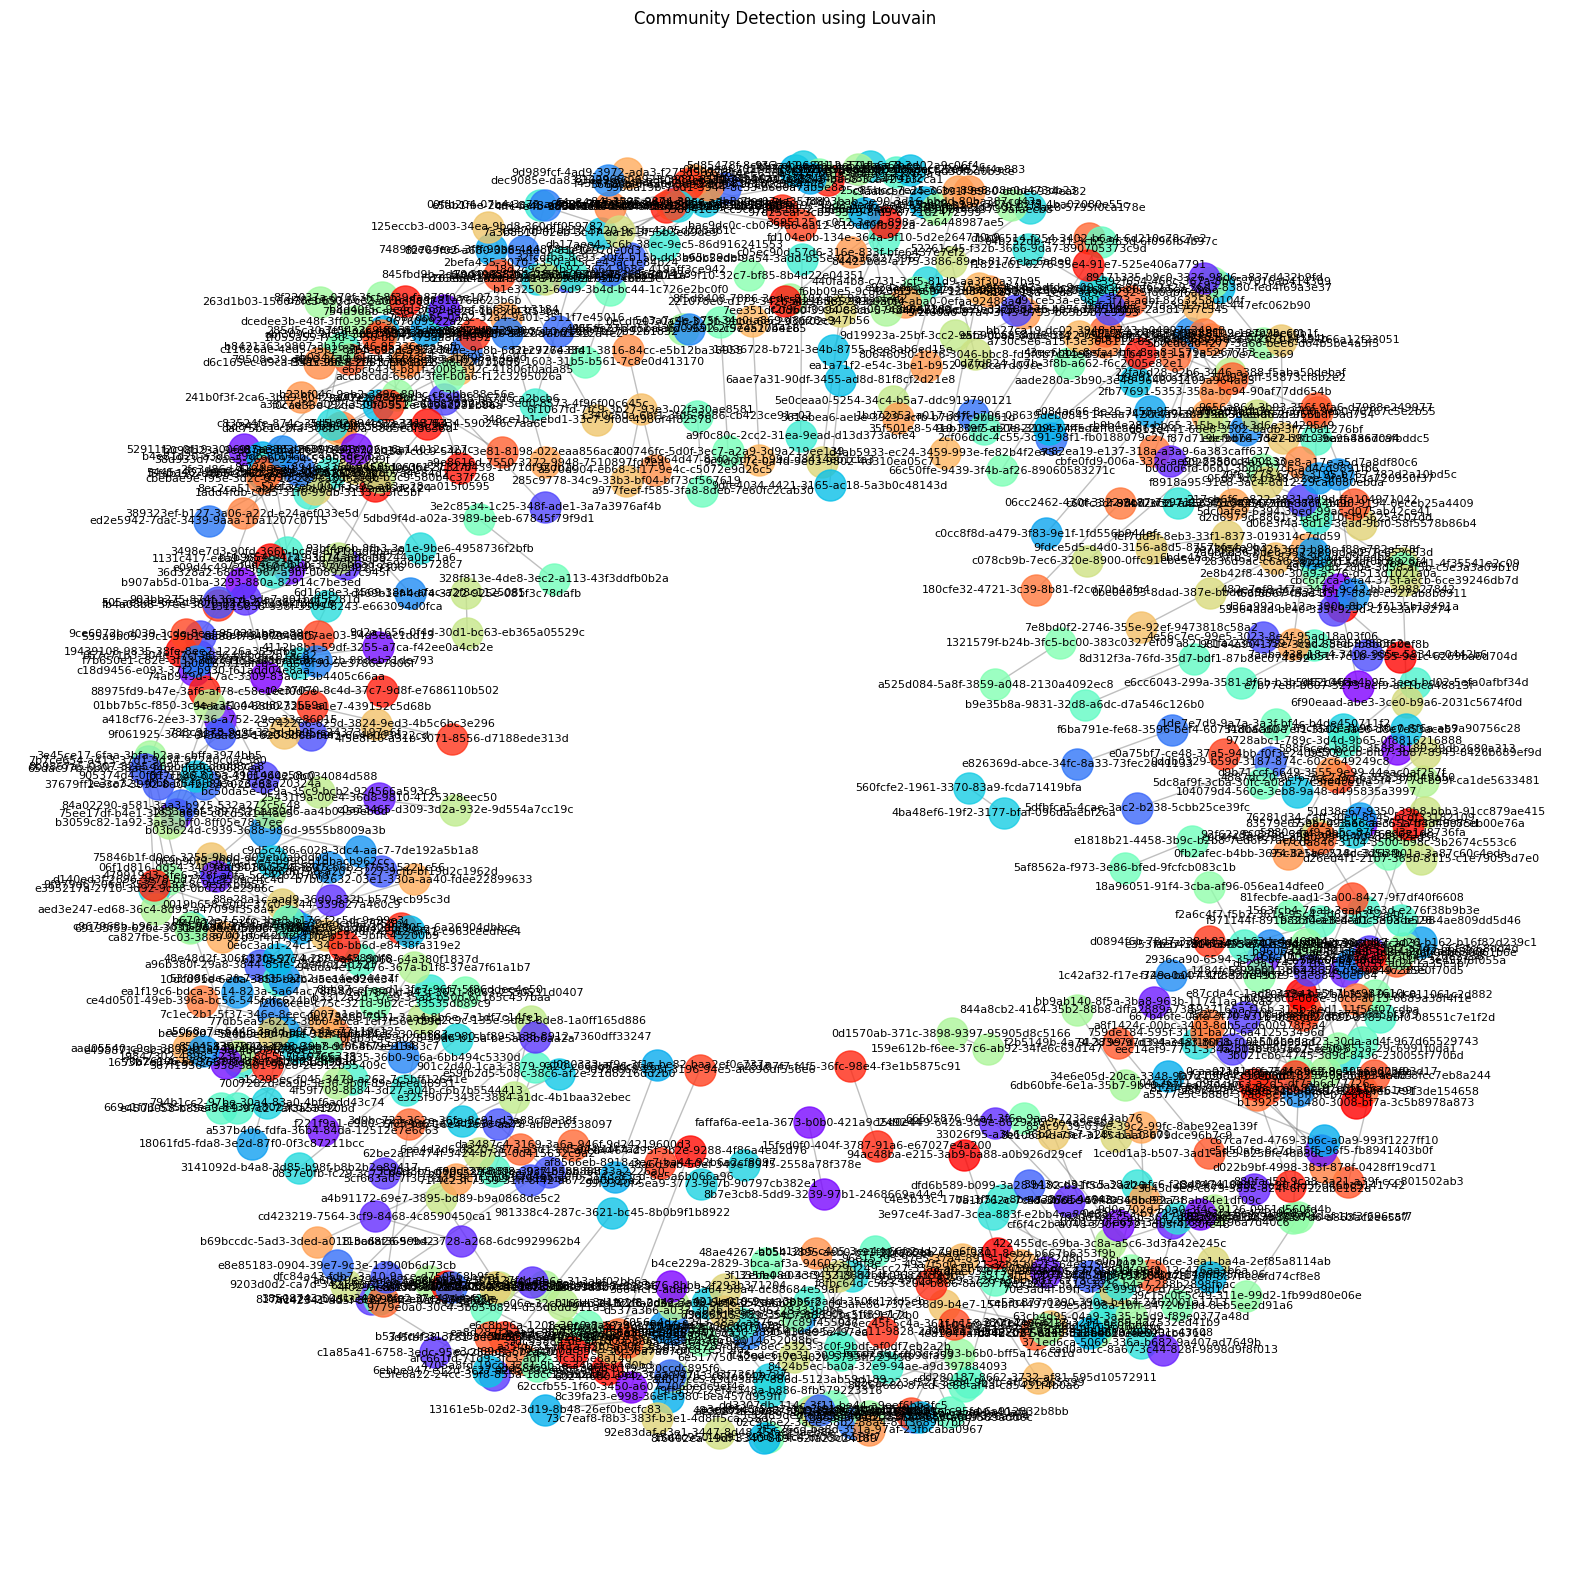

In [41]:
visualize_communities(G=graph, partition=partition)

In [42]:
gemini_client.models.generate_content(
  model=GEMINI_FLASH_MODEL,
  contents=[f"""
    This is the initial user query asked by the user: {user_query}

    and this is the data after the graph calculation: {partition}. Please reply the user whatever info the user is asking."""
  ]
).text


'Here are the communities of patients with shared conditions, based on the provided data. The numbers represent the size of each community:\n\n*   **Size 0:** 2 communities\n*   **Size 1:** 2 communities\n*   **Size 2:** 2 communities\n*   **Size 3:** 2 communities\n*   **Size 4:** 2 communities\n*   **Size 5:** 2 communities\n*   **Size 6:** 2 communities\n*   **Size 7:** 2 communities\n*   **Size 8:** 2 communities\n*   **Size 9:** 2 communities\n*   **Size 10:** 2 communities\n*   **Size 11:** 2 communities\n*   **Size 12:** 2 communities\n*   **Size 13:** 2 communities\n*   **Size 14:** 2 communities\n*   **Size 15:** 2 communities\n*   **Size 16:** 2 communities\n*   **Size 17:** 2 communities\n*   **Size 18:** 2 communities\n*   **Size 19:** 2 communities\n*   **Size 20:** 2 communities\n*   **Size 21:** 2 communities\n*   **Size 22:** 2 communities\n*   **Size 23:** 2 communities\n*   **Size 24:** 2 communities\n*   **Size 25:** 2 communities\n*   **Size 26:** 2 communities\n*  